

```
Issues
1. active promoter predicts a bit higher condensability (corrected)
2. incorporate mass spectrometry data
3. NMF instead of ChromHMM (corrected)
4. what is source of AT content dependency (corrected)
```



# PTM based prediction

In [1]:
# condense-seq data

import pandas as pd
df = pd.read_csv('/content/drive/Shareddrives/Jonghan_Park_Projects/(3)condense-seq/data/H1_NCP_sp_1rep_deep_chr1_score_table.gtab', sep='\t')
df.head(3)

,Chromosome,Position,H1_NCP_sp_4_1rep_deep,H1_NCP_sp_8_1rep_deep,Sequence,ATcontent,CNumber(CHG),meCNumber(CHG),CNumber(CHH),meCNumber(CHH),...,H3K4me3,H3K56ac,H3K79me1,H3K79me2,H3K9ac,H3K9me3,H4K20me1,H4K5ac,H4K8ac,H4K91ac
0,chr1,10144,1.48052,2.00553,CTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAA...,0.50292,0,0.0,56,0.15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,367.5399,0.0
1,chr1,10277,1.56351,1.97544,AACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCCTAAC...,0.46199,0,0.0,30,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,725.6557,0.0
2,chr1,10446,1.56187,1.92687,CTAACCCTAACCCTAACCCTAACCCTAACCCCTAACCCCTAACCCT...,0.40936,17,0.0,70,0.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0


In [2]:
# nmf data

nmf = pd.read_csv('/content/drive/Shareddrives/Jonghan_Park_Projects/(3)condense-seq-3/data/H1_NCP_sp_NMF_NCPClass.txt', sep='\t')
nmf.head(1)

,ID,Class#
0,"('chr1', 99415507)",1


In [3]:
# chromhmm data load

f = open('/content/drive/Shareddrives/Jonghan_Park_Projects/(3)condense-seq-3/data/H1_12_segments.bed')
lines = f.readlines()
f.close()
lines = [i.strip().split('\t') for i in lines]
lines_ = []
for l in lines:
    if(l[0]=='chr1'): lines_.append(l)
print(len(lines_))

hmm = []
idx = 0
from tqdm import tqdm
for i in tqdm(range(len(df))):
    if(df['Chromosome'][i] != 'chr1'): continue
    while(df['Position'][i] > int(lines_[idx][2])): idx += 1
    if(df['Position'][i] >= int(lines_[idx][1]) and df['Position'][i] <= int(lines_[idx][2])):
        hmm.append(lines_[idx][3])
print(len(df[df['Chromosome']=='chr1']), len(hmm))

51824


100%|██████████| 1521325/1521325 [00:44<00:00, 34007.50it/s]


1521325 1521325


In [4]:
chr = list(nmf['ID'])
chr = [i.split('\'')[1] for i in chr]

pos = list(nmf['ID'])
pos = [int(i[9:-1]) for i in pos]

temp = [(pos[i], nmf['Class#'][i]) for i in range(len(nmf))]
temp = sorted(temp)
print(len(temp))
print(temp[:3])
print(len(df[df['Chromosome']=='chr1']))

1521325
[(10144, 8), (10277, 8), (10446, 3)]
1521325


In [13]:
# mean normalization - should be corrected by MS data?
for i in range(12, len(df.columns)): df[df.columns[i]] /= df[df.columns[i]].mean()

In [24]:
# x - ptm chip
# y - condensability
# c - nmf class
# e - hmm class

import numpy as np
from tqdm import tqdm
x, y, c, e = [], [], [], []
for i in tqdm(range(len(df))):
    if(sum(df.loc[i, 'H2AFZ':])==0): continue
    x.append(df.loc[i, 'H2AFZ':])
    y.append(df['H1_NCP_sp_8_1rep_deep'][i])
    c.append(temp[i][1])
    e.append(int(hmm[i][1:]))
x = np.array(x)
y = np.array(y)
c = np.array(c)
e = np.array(e)

100%|██████████| 1521325/1521325 [07:22<00:00, 3435.11it/s]


In [15]:
# ptm lib load

ptm = pd.read_csv('/content/drive/Shareddrives/Jonghan_Park_Projects/(3)condense-seq-3/data/Data set3 (PTM library score data)/PTMlib_sp_score.txt', sep='\t')
ptm.head(1)

,ID,score (rep-1),score (rep-2),score (rep-3),Mean,Std
0,1,3.055531,3.012366,3.051474,3.03979,0.019463


In [16]:
# calculate average condensability for each ptm modification

import numpy as np
matrixidx = [[91, 92],
             [86],
             [83],
             [76],
             [77],
             [79],
             [74],
             [37],
             [38, 41],
             [39],
             [], # not found
             [40],
             [21, 22, 23 ,24 ,25, 26, 27, 28, 33],
             [59],
             [66],
             [102],
             [103],
             [7,8,9,10,11,12,13,30,61],
             [69],
             [], # not found
             [], # not found
             [36],
             [14,15,16,17,18,19,20,31],
             [], # not found
             [1,8,15,22],
             [2,9,16,23],
             [50]] # total 27
# print(len(matrixidx))

matrixweight = []
for i in range(len(matrixidx)):
    if(len(matrixidx[i])==0): matrixweight.append(0)
    else:
        _ = []
        for j in range(len(matrixidx[i])):
            # 42 ; 42	H2A 	H2B 	H3 	H4 	NA	CGACGT
            _.append(ptm['Mean'][matrixidx[i][j]-1]-ptm['Mean'][42-1])
        matrixweight.append(np.mean(_))
print(len(matrixweight), matrixweight[:3])

27 [-3.044780589165604, 0.0006450394722383734, 0.88991696154865]


PearsonRResult(statistic=0.491241380678065, pvalue=0.0)


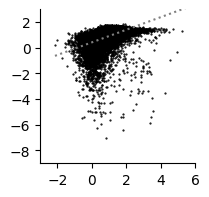

In [33]:
# predict condensability based on ptm library
# simple linear model

x2, y2, c2, e2 = [], [], [], []
for i in range(len(x)):
    if(sum(x[i]!=0) <= 5): continue
    x2.append(x[i])
    y2.append(y[i])
    c2.append(c[i])
    e2.append(e[i])
x2 = np.array(x2)
y2 = np.array(y2)
c2 = np.array(c2)
e2 = np.array(e2)

inner = np.inner(x2, matrixweight)
inner /= inner.std()/y2.std()
inner -= inner.mean()-y2.mean()
import scipy
print(scipy.stats.pearsonr(y2, inner))

import matplotlib.pyplot as plt
plt.figure(figsize=(2, 2))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.scatter(y2, inner, c='k', s=0.3)

_ = plt.xlim(-3, 6)
_ = plt.ylim(-9, 3)
_ = plt.xticks([-2, 0, 2, 4, 6])
_ = plt.yticks([-8, -6, -4, -2, 0, 2])

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(y2.reshape(-1, 1), inner)
X_new = np.array([[y2.min()], [y2.max()]])
y_predict = lin_reg.predict(X_new)
plt.plot(X_new, y_predict, color="gray", linestyle=':')

plt.savefig('./fig_prediction.png', format='png', dpi=1200, transparent=True)

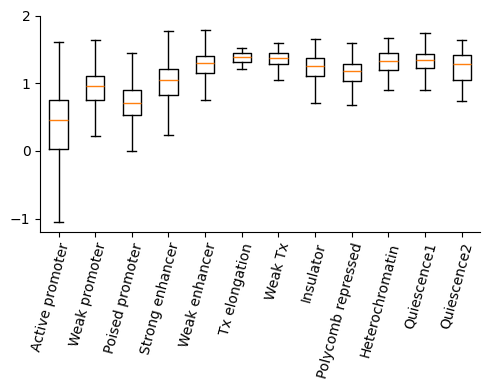

In [34]:
# ChromHMM classification

label = ['Active promoter', 'Weak promoter', 'Poised promoter', 'Strong enhancer',
         'Weak enhancer', 'Tx elongation', 'Weak Tx', 'Insulator',
         'Polycomb repressed', 'Heterochromatin', 'Quiescence1', 'Quiescence2']
hmmidx = [5, 3, 2, 4, 6, 10, 11, 12, 1, 9, 7, 8]

plt.figure(figsize=(5, 4))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
_ = plt.boxplot([inner[np.where(e2==hmmidx[i])] for i in range(12)], showfliers=False)
_ = plt.xticks(range(1, 13), label, rotation=75, ha='right', rotation_mode="anchor")
_ = plt.yticks([-1, 0, 1, 2])

plt.tight_layout()
plt.savefig('./fig_chromhmm.svg', dpi=1200, transparent=True, format='svg')

PearsonRResult(statistic=0.8408544701866812, pvalue=0.0006115209966049491)


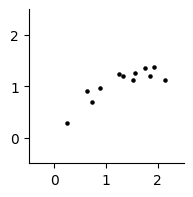

In [36]:
# chromhmm (measured vs PTM predicted)

a, b = [], []
for i in range(1, 13):
    ytemp, itemp = y2[np.where(e2==i)], inner[np.where(e2==i)]
    # print(i, y2[np.where(e2==i)].mean())
    # print(i, inner[np.where(e2==i)].mean())
    a.append(ytemp.mean())
    b.append(itemp.mean())
print(scipy.stats.pearsonr(a, b))

plt.figure(figsize=(2, 2))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.scatter(a, b, c='k', s=5)

_ = plt.xlim(-0.5, 2.5)
_ = plt.ylim(-0.5, 2.5)

plt.savefig('./fig_chromhmm_corr.svg', dpi=1200, transparent=True, format='svg')

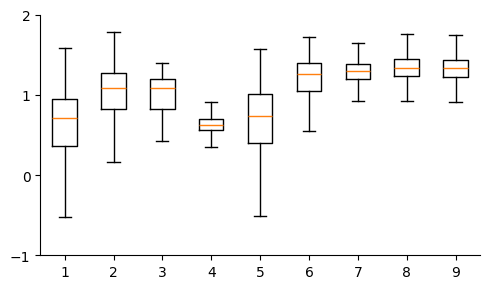

In [47]:
# NMF classification
# NMF class 10 has few histone markers - PTM library prediction not accurate

annotation = [8, 1, 7, 4, 3, 6, 2, 9, 5, 10][:-1]

plt.figure(figsize=(5, 3))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
_ = plt.boxplot([inner[np.where(c2==annotation.index(i)+1)] for i in range(1, 10)], showfliers=False)
_ = plt.xticks(range(1, 10))
_ = plt.yticks([-1, 0, 1, 2])

plt.tight_layout()
plt.savefig('./fig_nmf.svg', dpi=1200, transparent=True, format='svg')

PearsonRResult(statistic=0.8050005432926111, pvalue=0.008857589014604044)


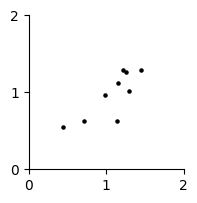

In [38]:
# NMF (predicted vs PTM corrected)

annotation = [8, 1, 7, 4, 3, 6, 2, 9, 5, 10]
a, b = [], []
for i in range(1, 10):
    itemp, ytemp = inner[np.where(c2==i)], y2[np.where(c2==i)]
    a.append(ytemp.mean())
    b.append(itemp.mean())

print(scipy.stats.pearsonr(a, b))

plt.figure(figsize=(2, 2))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.scatter(a, b, c='k', s=5)

_ = plt.xlim(0, 2)
_ = plt.ylim(0, 2)
_ = plt.xticks([0, 1, 2])
_ = plt.yticks([0, 1, 2])

plt.savefig('./fig_nmf_corr.svg', dpi=1200, transparent=True, format='svg')

# issues regarding AT dependency

In [1]:
import pandas as pd
df = pd.read_csv('/content/drive/Shareddrives/Jonghan_Park_Projects/(3)condense-seq/data/H1_NCP_sp_1rep_deep_chr1_score_table.gtab', sep='\t')
df.head(3)

,Chromosome,Position,H1_NCP_sp_4_1rep_deep,H1_NCP_sp_8_1rep_deep,Sequence,ATcontent,CNumber(CHG),meCNumber(CHG),CNumber(CHH),meCNumber(CHH),...,H3K4me3,H3K56ac,H3K79me1,H3K79me2,H3K9ac,H3K9me3,H4K20me1,H4K5ac,H4K8ac,H4K91ac
0,chr1,10144,1.48052,2.00553,CTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAA...,0.50292,0,0.0,56,0.15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,367.5399,0.0
1,chr1,10277,1.56351,1.97544,AACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCCTAAC...,0.46199,0,0.0,30,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,725.6557,0.0
2,chr1,10446,1.56187,1.92687,CTAACCCTAACCCTAACCCTAACCCTAACCCCTAACCCCTAACCCT...,0.40936,17,0.0,70,0.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0


In [2]:
def polynt_count(seq, nts, pos=False):
    len_pos = {}
    i = 0
    while i < len(seq):
        if seq[i] in nts:
            nt = seq[i]
            count = 1
            j = i + 1
            while j < len(seq):
                if seq[j] != nt:
                    break
                count +=1
                j +=1
            if count not in len_pos:
                len_pos[count] = []
            len_pos[count].append(i)
            i = j
        else:
            i +=1
    if pos:
        return len_pos
    if len(len_pos) == 0:
        return 0
    return max(len_pos.keys())

In [3]:
import numpy as np
def get_fract_dict (ID_test,
                    ID_control,
                    IDs=None,
                    dummy_addon=0,
                    div_error=np.NaN):

    if IDs == None:
        IDs = set(ID_test.keys()) | set(ID_control.keys())

    ID_fract = {}
    for ID in IDs:
        try:
            test = float(ID_test[ID])
        except:
            test = 0.0
        try:
            control = float(ID_control[ID])
        except:
            control = 0.0

        test += dummy_addon
        control += dummy_addon

        if control <= 0:
            ID_fract[ID] = div_error
            continue

        fract = test / control
        ID_fract[ID] = fract
    return ID_fract

In [4]:
### compute sequence features
# methylation density
df['meCpG density'] = get_fract_dict(df['meCNumber(CpG)'],
                                                       df['CNumber(CpG)'],
                                                       div_error=0.0)
df['meCHG density'] = get_fract_dict(df['meCNumber(CHG)'],
                                                       df['CNumber(CHG)'],
                                                       div_error=0.0)
df['meCHH density'] = get_fract_dict(df['meCNumber(CHH)'],
                                                       df['CNumber(CHH)'],
                                                       div_error=0.0)

In [5]:
### compute sequence features
# mean poly GC length
ID_polyGC = {}
for ID, seq in df['Sequence'].items():
    num_pos = polynt_count(seq.upper(), nts='GC', pos=True)
    mean_len, count = 0.0, 0.0
    for num, pos in num_pos.items():
        mean_len += len(pos)*num
        count += len(pos)
    ID_polyGC[ID] = mean_len/count

df['poly-G/C length'] = ID_polyGC

del df['Sequence']
del ID_polyGC

In [7]:
### select feature set and target for analysis
feature_names = ['ATcontent', 'poly-G/C length', 'meCpG density', 'meCHG density', 'meCHH density', 'H2AFZ', 'H2AK5ac', 'H2BK120ac', 'H2BK12ac', 'H2BK15ac', 'H2BK20ac', 'H2BK5ac', 'H3K14ac', 'H3K18ac', 'H3K23ac', 'H3K23me2', 'H3K27ac', 'H3K27me3', 'H3K36me3', 'H3K4ac', 'H3K4me1', 'H3K4me2', 'H3K4me3', 'H3K56ac', 'H3K79me1', 'H3K79me2', 'H3K9ac', 'H3K9me3', 'H4K20me1', 'H4K5ac', 'H4K8ac', 'H4K91ac']
print(len(feature_names))

32


In [9]:
# chromosome 1

import pandas as pd
import numpy as np
a1 = pd.read_csv('/content/drive/Shareddrives/Jonghan_Park_Projects/(3)condense-seq/H1/H1_NCP_sp_0_1rep_deep_chr1_Ncov.gtab', sep='\t')
b1 = pd.read_csv('/content/drive/Shareddrives/Jonghan_Park_Projects/(3)condense-seq/H1/H1_NCP_sp_8_1rep_deep_chr1_Ncov.gtab', sep='\t')
a2 = pd.read_csv('/content/drive/Shareddrives/Jonghan_Park_Projects/(3)condense-seq/H1/H1_NCP_sp_0_2rep_deep_chr1_Ncov.gtab', sep='\t')
b2 = pd.read_csv('/content/drive/Shareddrives/Jonghan_Park_Projects/(3)condense-seq/H1/H1_NCP_sp_8_2rep_deep_chr1_Ncov.gtab', sep='\t')
data1 = df[feature_names]

In [10]:
import re
def is_valid_dna_sequence(sequence):
    pattern = re.compile("^[atgcATGC]+$")
    return bool(pattern.match(sequence))

C, Q = [], []
from tqdm import tqdm
for i in tqdm(range(len(data1))):
    if(a1['H1_NCP_sp_0_1rep_deep'][i] > 15000): continue
    C.append(df['H1_NCP_sp_8_1rep_deep'][i])
    Q.append(list(data1.loc[i,'ATcontent':]))
C = np.array(C)
print(C.shape)

100%|██████████| 1521325/1521325 [05:01<00:00, 5051.55it/s]


(1519405,)


In [11]:
input = np.array(Q)

In [12]:
from sklearn.model_selection import train_test_split

sample_size = input.shape[0] # number of samples in train set
time_steps  = input.shape[1] # number of features in train set
input_dimension = 1               # each feature is represented by 1 number
re_input = input.reshape(sample_size,time_steps,input_dimension)

x_train, x_test, y_train, y_test = train_test_split(re_input, np.array(C), test_size=0.1)

In [13]:
x_train.shape, y_train.shape

((1367464, 32, 1), (1367464,))

In [14]:
from xgboost import plot_importance
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=5)
xgb.fit(x_train.reshape(-1, 32), y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [15]:
xgb_pred = xgb.predict(x_test.reshape(-1, 32))
import scipy
print(scipy.stats.pearsonr(y_test, xgb_pred))
print(len(y_test))

PearsonRResult(statistic=0.6161119257060157, pvalue=0.0)
151941


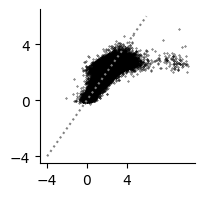

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(2, 2))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.scatter(y_test, xgb_pred, c='k', s=0.1)
_ = plt.xticks([-4, 0, 4])
_ = plt.yticks([-4, 0, 4])

plt.plot([-4, 6], [-4, 6], c='gray', linestyle=':')
plt.savefig('./fig.png', format='png', dpi=1200, transparent=True)

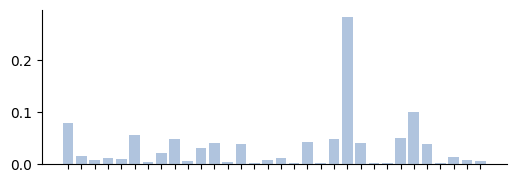

In [17]:
imp = list(xgb.get_booster().get_score(importance_type="gain").values())
imp = np.array(imp)/sum(imp)

plt.figure(figsize=(6, 2))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.bar(range(len(imp)), imp, facecolor='lightsteelblue')
_ = plt.xticks(range(len(imp)), visible=False)

plt.savefig('./fig_xgboost.svg', format='svg', dpi=1200, transparent=True)

In [20]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(min_samples_leaf=3,
                                n_estimators=198,
                                max_depth=20,
                                max_features=2,
                                min_samples_split=1000)
gb.fit(x_train.reshape(-1, 32), y_train)

GradientBoostingRegressor(max_depth=20, max_features=2, min_samples_leaf=3,
                          min_samples_split=1000, n_estimators=198)

In [23]:
corr, _ = scipy.stats.pearsonr(y_test, gb.predict(x_test.reshape(-1, 32)))
print(corr)

0.6202890993199244


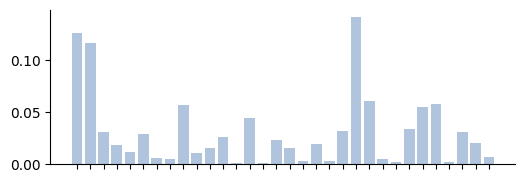

In [25]:
imp = list(gb.feature_importances_ )
imp = np.array(imp)/sum(imp)

plt.figure(figsize=(6, 2))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.bar(range(len(imp)), imp, facecolor='lightsteelblue')
_ = plt.xticks(range(len(imp)), visible=False)

plt.savefig('./fig_boosting.svg', format='svg', dpi=1200, transparent=True)